In [24]:
# Libraries import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("images"):
    os.mkdir("images")

# Parameter : show all columns when dataframe is visualized
pd.set_option('display.max_columns', None)

In [25]:
def sqrt_trans(number):
    if number == 0:
        return 0
    else:
        return math.sqrt(number)

In [26]:
#File imports with negative and positive modes separated
neg_sirius = pd.read_csv('Clementine/NEG_ProvOff_canopus_compound_summary.tsv', sep='\t') #insert here local pathway to canopus compounds summary  
neg_mzmine = pd.read_csv('Clementine/NEG_ProvenceOfficine_MolNotator.csv', sep=',') #insert here local pathway to csv file exported from MZmine
neg_metadata = pd.read_csv('Clementine/NEG_METADATA.txt',sep='\t') #insert here local pathway to Metadata file 

pos_sirius = pd.read_csv('Clementine/POS_ProvOff_canopus_compound_summary.tsv', sep='\t') #insert here local pathway to canopus compounds summary 
pos_mzmine = pd.read_csv('Clementine/POS_ProvenceOfficine_MolNotator.csv', sep=',')  #insert here local pathway to csv file exported from MZmine
pos_metadata = pd.read_csv('Clementine/POS_METADATA.txt',sep='\t') #insert here local pathway to Metadata file 

In [27]:
#Metadatas list
[i.replace('ATTRIBUTE_','') for i in pos_metadata.columns if i.startswith('ATTRIBUTE_')]

['Species', 'Family']

In [28]:
#Chemical family list
['NPC#pathway', 'NPC#superclass','NPC#class'] #'ClassyFire#most specific class', 'ClassyFire#level 5', 'ClassyFire#superclass', 'ClassyFire#class'

['NPC#pathway', 'NPC#superclass', 'NPC#class']

In [29]:
#Recover subclasses ontology
tree = pd.read_excel('Clementine/NPClassifier.xlsx')
#tree[(tree['Pathway'] == 'Alkaloids') & (tree['Superclass'] == 'Tyrosine alkaloids')]['Class'].to_list()
#tree[(tree['Pathway'] == 'Alkaloids')]['Class'].to_list()
tree.loc[:,'Superclass'].unique()

array(['Ornithine alkaloids', 'Tyrosine alkaloids',
       'Tryptophan alkaloids', 'Anthranilic acid alkaloids',
       'Guanidine alkaloids', 'Pseudoalkaloids', 'Peptide alkaloids',
       'Tetramate alkaloids', 'Mitomycin derivatives',
       'Proline alkaloids', 'Lysine alkaloids', 'Serine alkaloids',
       'Miscellaneous alkaloids', 'Nicotinic acid alkaloids',
       'Histidine alkaloids', 'Macrolides', 'Linear polyketides',
       'Cyclic polyketides', 'Mycosporine derivatives', 'Oligopeptides',
       'β-lactams', 'γ-lactam-β-lactones', 'Amino acid glycosides',
       'Phenylpropanoids (C6-C3)', 'Small peptides', 'Polyols',
       'Nucleosides', 'Saccharides', 'Aminosugars and\naminoglycosides',
       'Fatty Acids and Conjugates', 'Octadecanoids', 'Eicosanoids',
       'Docosanoids', 'Fatty esters', 'Fatty amides', 'Fatty acyls',
       'Fatty acyl glycosides', 'Glycerolipids', 'Glycerophospholipids',
       'Sphingolipids', 'Chromanes', 'Alkylresorcinols',
       'Aromatic pol

In [30]:
#Choose which type do you want to do:
chemical_family = 'NPC#pathway' #Should be lower than class_item #Superclass or class if want to see the second part, otherwise pathway for the general
metadata = 'Species'

class_item = 'Superclass' #Pathway or superclass
item2 = 'Sesquiterpenoids'

In [31]:
#Transform id sirius to mzmine id
for row_ind, row in neg_sirius.iterrows():
    neg_sirius.loc[row_ind, 'mzmine_id'] = int(neg_sirius.loc[row_ind, "id"].split('_')[-1])
for row_ind, row in pos_sirius.iterrows():
    pos_sirius.loc[row_ind, 'mzmine_id'] = int(pos_sirius.loc[row_ind, "id"].split('_')[-1])

In [32]:
#Combine two dfs by mzmine id
neg_df = neg_sirius.merge(neg_mzmine, left_on='mzmine_id', right_on='row ID', how='inner')
pos_df = pos_sirius.merge(pos_mzmine, left_on='mzmine_id', right_on='row ID', how='inner')

In [33]:
#Take list of unique values
unique_values = neg_df[chemical_family].unique()
unique_values = pos_df[chemical_family].unique()

In [34]:
#Keep only what is important
neg_final_df = neg_df[['row ID', 'molecularFormula', 'adduct', 'NPC#pathway','NPC#superclass', 'NPC#class', 'ClassyFire#most specific class', 'ClassyFire#level 5', 'ClassyFire#superclass', 'ClassyFire#class', 'row m/z', 'row retention time']].copy()
pos_final_df = pos_df[['row ID', 'molecularFormula', 'adduct', 'NPC#pathway','NPC#superclass', 'NPC#class', 'ClassyFire#most specific class', 'ClassyFire#level 5', 'ClassyFire#superclass', 'ClassyFire#class', 'row m/z', 'row retention time']].copy()

In [35]:
#Recover list of metadata
pos_espece = dict()
neg_espece = dict()
for species in neg_metadata['ATTRIBUTE_' + metadata].unique()[1:]:
    neg_espece[species] = neg_metadata[neg_metadata['ATTRIBUTE_' + metadata] == species]['filename'].tolist()
for species in pos_metadata['ATTRIBUTE_' + metadata].unique()[1:]:
    pos_espece[species] = pos_metadata[pos_metadata['ATTRIBUTE_' + metadata] == species]['filename'].tolist()

In [36]:
for species, files in neg_espece.items():
    neg_espece[species] = [x + ' Peak area' for x in files]
for species, files in pos_espece.items():
    pos_espece[species] = [x + ' Peak area' for x in files]

In [37]:
for species, files in neg_espece.items():
    neg_final_df.loc[:,species] = neg_df.loc[:,neg_espece[species]].sum(axis=1)
for species, files in pos_espece.items():
    pos_final_df.loc[:,species] = pos_df.loc[:,pos_espece[species]].sum(axis=1)

In [38]:
#Create new df with grouped by chemical family
neg_superclass = neg_final_df.groupby(chemical_family).sum()
pos_superclass = pos_final_df.groupby(chemical_family).sum()

In [39]:
#Create new df with grouped by chemical family and sqrt transformation
neg_superclass_sqrt = neg_superclass.copy()
pos_superclass_sqrt = pos_superclass.copy()

In [40]:
neg_species_list = neg_metadata['ATTRIBUTE_' + metadata].unique()[1:]
pos_species_list = pos_metadata['ATTRIBUTE_' + metadata].unique()[1:]

In [41]:
for species in neg_species_list:
    neg_superclass_sqrt[species] = neg_superclass_sqrt[species].apply(sqrt_trans)
for species in pos_species_list:
    pos_superclass_sqrt[species] = pos_superclass_sqrt[species].apply(sqrt_trans)

In [42]:
#Height and width depending on data type
size = {'NPC#pathway': [500, 750, 0.6], 'NPC#superclass': [1500, 500, 0.5] ,'NPC#class':[5500, 700, 0.5]}

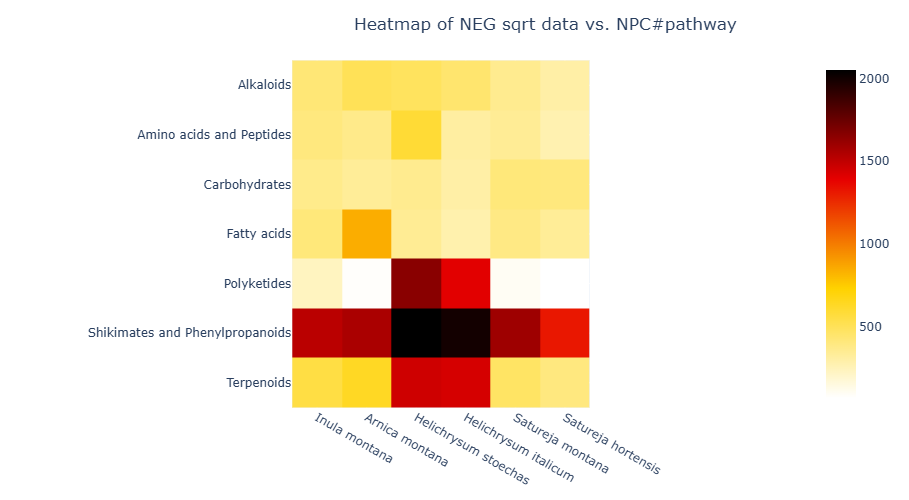

In [43]:
import plotly.express as px

# Pivot the DataFrame to make 'NPC#superclass' the index and columns 'NEG_IM' to 'NEG_SH' as values
pivot_df = neg_superclass_sqrt.pivot(columns=[], values=neg_metadata['ATTRIBUTE_' + metadata].unique()[1:])

# Get the row and column names for the heatmap
row_names = neg_superclass_sqrt.index.to_list()
column_names = pivot_df.columns

# Create a heatmap using Plotly Express
fig = px.imshow(pivot_df.values, x=column_names, y=row_names , color_continuous_scale='hot_r')

# Set plot labels and title
fig.update_layout(
    #xaxis=dict(title='sqrt Columns'),
    #yaxis=dict(title=chemical_family),
    title='Heatmap of NEG sqrt data vs. ' + chemical_family,
    title_x=size[chemical_family][2],
    height=size[chemical_family][0],
    width=size[chemical_family][1]
)

# Show the plot
#fig.show()
#fig.write_image("clementine_images/Prov_Off_NEG_pathway.svg")


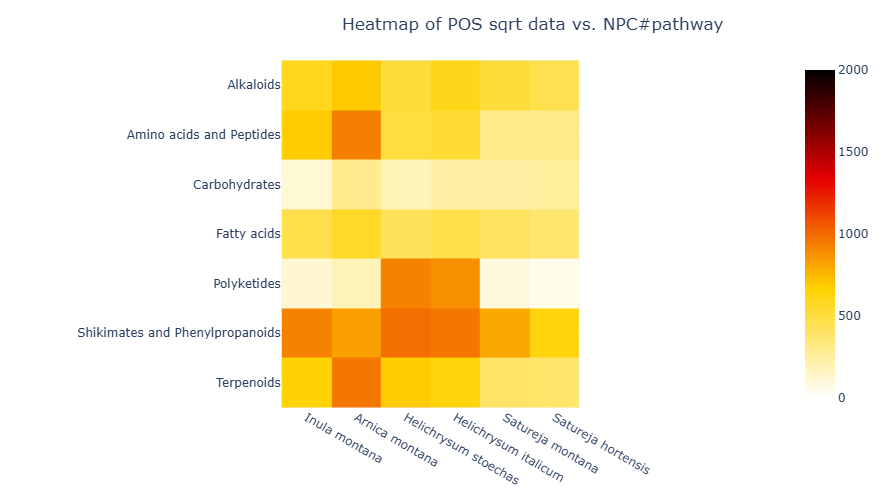

In [48]:
import plotly.express as px

# Pivot the DataFrame to make 'NPC#superclass' the index and columns 'NEG_IM' to 'NEG_SH' as values
pivot_df = pos_superclass_sqrt.pivot(columns=[], values=pos_metadata['ATTRIBUTE_' + metadata].unique()[1:])

# Get the row and column names for the heatmap
row_names = pos_superclass_sqrt.index.to_list()
column_names = pivot_df.columns

# Create a heatmap using Plotly Express
fig = px.imshow(pivot_df.values, x=column_names, y=row_names , color_continuous_scale='hot_r', zmin=0, zmax=2000)

# Set plot labels and title
fig.update_layout(
    #xaxis=dict(title='sqrt Columns'),
    #yaxis=dict(title=chemical_family),
    title='Heatmap of POS sqrt data vs. ' + chemical_family,
    title_x=size[chemical_family][2],
    height=size[chemical_family][0],
    width=size[chemical_family][1]
)

# Show the plot
fig.show()
fig.write_image("clementine_images/Prov_Off_POS_pathway.svg")

In [608]:
pivot_df = neg_superclass_sqrt.loc[:,neg_metadata['ATTRIBUTE_' + metadata].unique()[1:]].copy()
column_list = [i for i in neg_superclass_sqrt.index.to_list() if i in tree[(tree[class_item] == item2)]['Class' if class_item == 'Superclass' else 'Superclass'].to_list()]
pivot_df = pivot_df.loc[column_list].copy()
diff = [i for i in neg_superclass_sqrt.index.to_list() if i in tree[(tree[class_item] == item2)]['Class' if class_item == 'Superclass' else 'Superclass'].to_list()]
new_one = list()
for i in tree[(tree[class_item] == item2)]['Class' if class_item == 'Superclass' else 'Superclass'].to_list():
    if i in diff:
        pass
    else:
        new_one.append(i)
for i in new_one:
    pivot_df.loc[i]=0

pivot_df = pivot_df.sort_index()

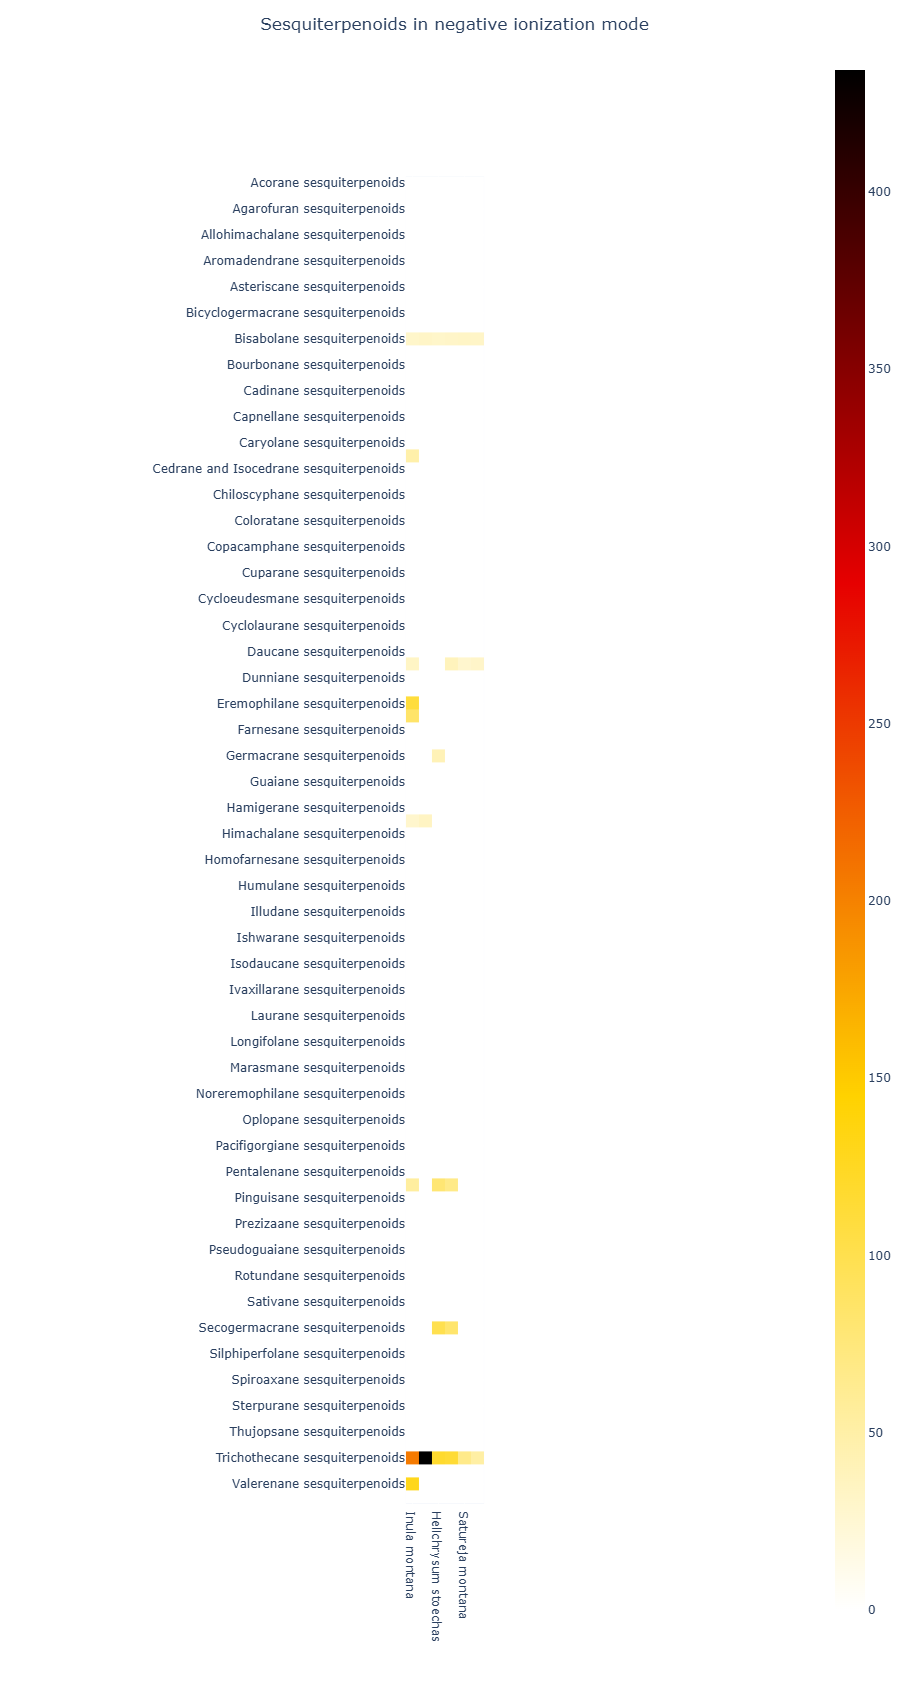

In [609]:
import plotly.express as px

# Pivot the DataFrame to make 'NPC#superclass' the index and columns 'NEG_IM' to 'NEG_SH' as values


# Get the row and column names for the heatmap
row_names = pivot_df.index.to_list()
column_names = pivot_df.columns.to_list()

# Create a heatmap using Plotly Express
fig = px.imshow(pivot_df.values, x=column_names, y=row_names , color_continuous_scale='hot_r')

# Set plot labels and title
fig.update_layout(
    #xaxis=dict(title='sqrt Columns'),
    #yaxis=dict(title=chemical_family),
    title= f'{item2} in negative ionization mode',
    title_x=0.5,
    height=1700,
    width=1000
)

# Show the plot
#fig.show()
#fig.write_image("clementine_images/ProvOff_NEG_"+ item2.replace('\n',' ') + ".svg")

In [610]:
pivot_df = pos_superclass_sqrt.loc[:,neg_metadata['ATTRIBUTE_' + metadata].unique()[1:]].copy()
column_list = [i for i in pos_superclass_sqrt.index.to_list() if i in tree[(tree[class_item] == item2)]['Class' if class_item == 'Superclass' else 'Superclass'].to_list()]
pivot_df = pivot_df.loc[column_list].copy()
diff = [i for i in pos_superclass_sqrt.index.to_list() if i in tree[(tree[class_item] == item2)]['Class' if class_item == 'Superclass' else 'Superclass'].to_list()]
new_one = list()
for i in tree[(tree[class_item] == item2)]['Class' if class_item == 'Superclass' else 'Superclass'].to_list():
    if i in diff:
        pass
    else:
        new_one.append(i)
for i in new_one:
    pivot_df.loc[i]=0
for ind, item in pivot_df.iterrows():
    if isinstance(ind, tuple):
        pivot_df = pivot_df.rename(index = {ind : ind[0]})
pivot_df = pivot_df.sort_index()

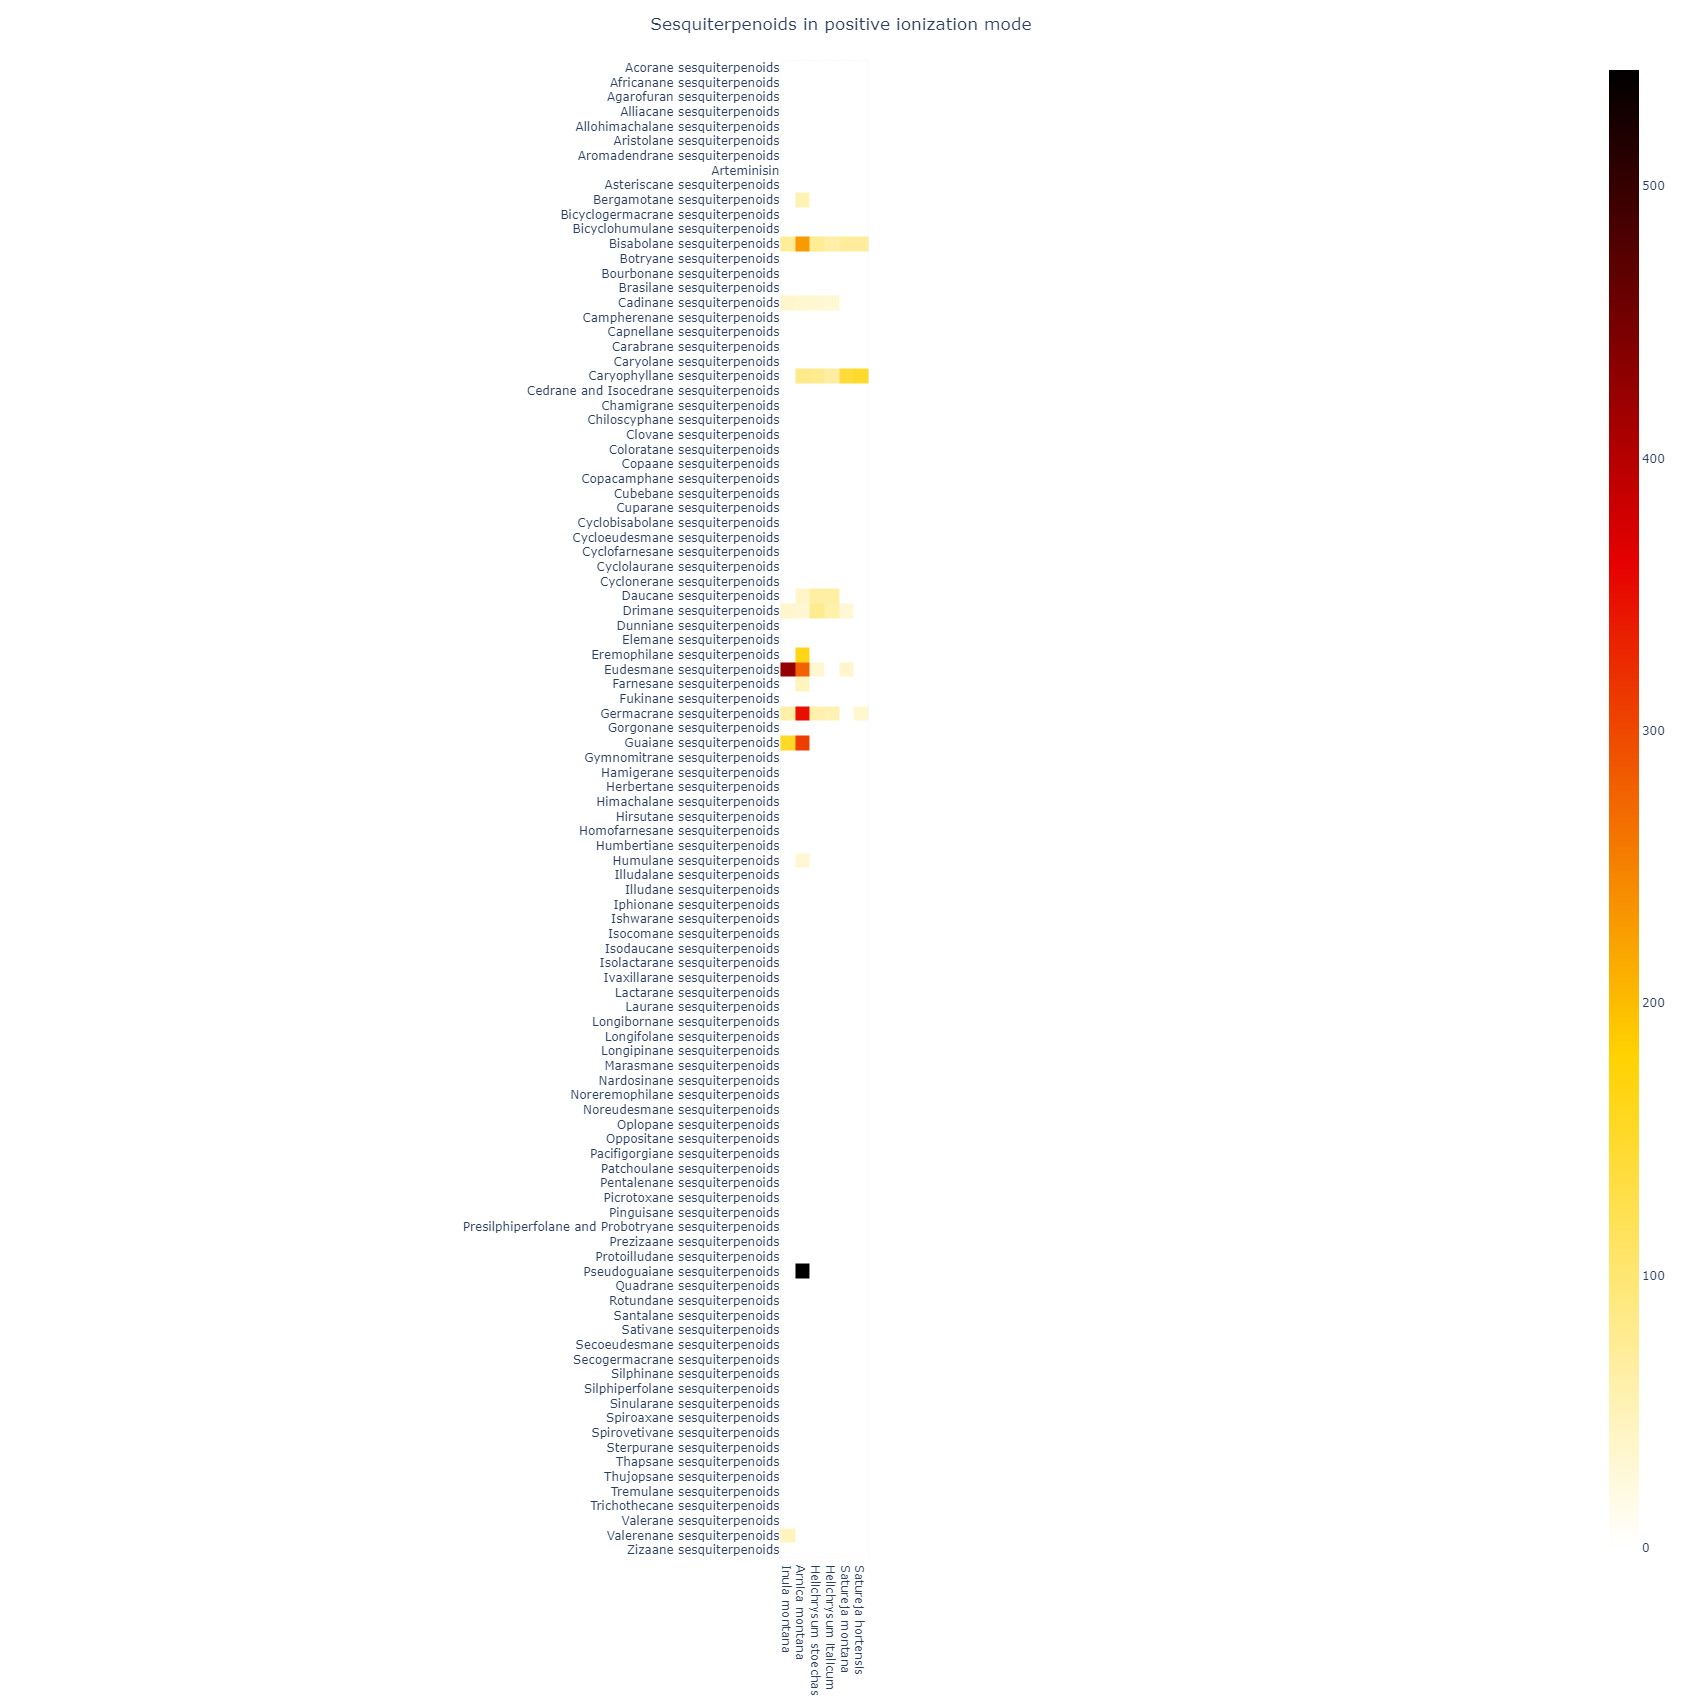

In [611]:
import plotly.express as px

# Pivot the DataFrame to make 'NPC#superclass' the index and columns 'NEG_IM' to 'NEG_SH' as values


# Get the row and column names for the heatmap
row_names = pivot_df.index.to_list()
column_names = pivot_df.columns.to_list()

# Create a heatmap using Plotly Express
fig = px.imshow(pivot_df.values, x=column_names, y=row_names , color_continuous_scale='hot_r')

# Set plot labels and title
fig.update_layout(
    #xaxis=dict(title='sqrt Columns'),
    #yaxis=dict(title=chemical_family),
    title= f'{item2} in positive ionization mode',
    title_x=0.5,
    height=1700,
    width=1000
)

# Show the plot
#fig.show()
#fig.write_image("clementine_images/ProvOff_POS_"+ item2.replace('\n',' ')+ ".svg")